## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *
from architecture.AutoEncoder import *
from torch.autograd import Variable

import math

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(969)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[2713, 1919, 3374, 523, 2578, 3443, 1627, 2597, 79]


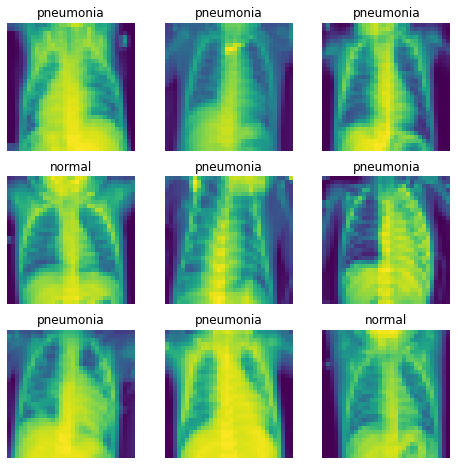

In [9]:
visualize_data(train_data)

[81, 385, 178, 57, 121, 179, 299, 197, 484]


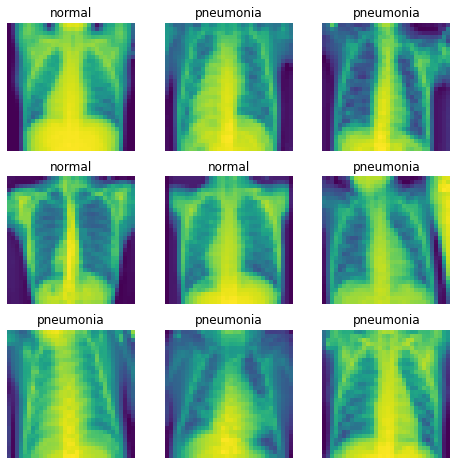

In [10]:
visualize_data(test_data)

## Initialize Autoencoder

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
# number of hidden layers and their sizes
hidden = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size = 3

In [13]:
autoencmodel = AutoEncoder(hidden, kernel_size).to(device)
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Train the AutoEncoder

In [14]:
outputs_list = []
loss_list = []
criterion = nn.MSELoss()
optimizer = create_adam_optimizer(autoencmodel, lr=0.001)

In [15]:
num_epochs = 4
for epoch in range(num_epochs):
    for data in train_loader:
        
        # Send data to device
        img, _ = data
        img = Variable(img).to(device)
        
        # Forward pass
        output = autoencmodel(img)
        loss = criterion(output, img)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Display
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    outputs_list.append((epoch, img, output),)
    loss_list.append(loss.item())

epoch 1/4, loss 0.7525
epoch 2/4, loss 0.7108
epoch 3/4, loss 0.6645
epoch 4/4, loss 0.6385


## Visualize AutoEncoder Outputs

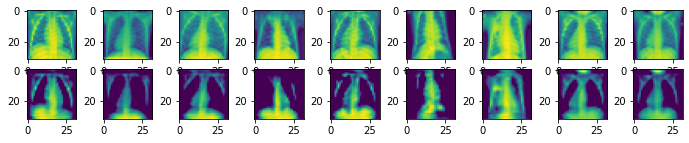

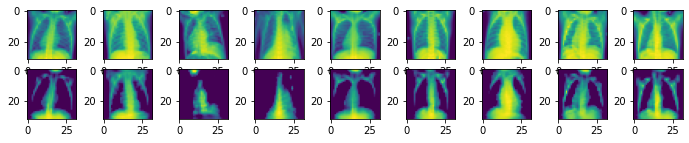

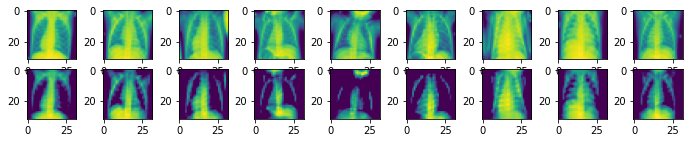

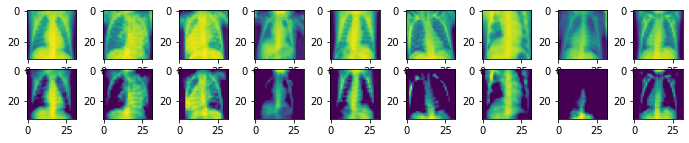

In [16]:
#display decoded images
for k in range(0, num_epochs):
    plt.figure(figsize = (12, 2))
    imgs = outputs_list[k][1].cpu().detach().numpy()
    recon = outputs_list[k][2].cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

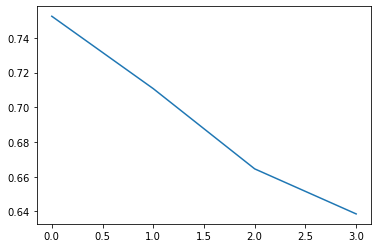

In [17]:
plt.figure()
plt.plot(loss_list)
plt.show()

## Saving Model

In [ ]:
torch.save({'model_state_dict': autoencmodel.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict()}, 
           './autoencoder256')